In [ ]:
labels_map = {
    0: 'eggtar',
    1: 'donut'
}

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from PIL import Image

# 에그타르트
# 이미지가 있는 폴더 경로 설정
eggtar_path = '/content/gdrive/MyDrive/Colab_Notebooks/데이터셋/에그타르트'

# 폴더 내의 jpg 파일 경로들 가져오기
eggtar_files = [file for file in os.listdir(eggtar_path) if file.endswith('.jpg')]

eggtar_images = [] # 바꾸기
for file in eggtar_files: # 바꾸기
    # 이미지 파일 경로
    img_path = os.path.join(eggtar_path, file) # 바꾸기

    # 이미지 읽기 및 사이즈 변경
    img = Image.open(img_path)
    resized_image = img.resize((160, 160))

    # 조정된 이미지를 넘파이 배열로 변환
    image_array = np.array(resized_image)

    # 이미지 배열 리스트에 추가
    eggtar_images.append(image_array) # 바꾸기

eggtar_dataset = [{'img': img, 'label': 0} for img in eggtar_images] # 바꾸기
len(eggtar_dataset) # 바꾸기

741

In [ ]:
# 도넛
# 이미지가 있는 폴더 경로 설정
donut_path = '/content/gdrive/MyDrive/Colab_Notebooks/데이터셋/도넛'

# 폴더 내의 jpg 파일 경로들 가져오기
donut_files = [file for file in os.listdir(donut_path) if file.endswith('.jpg')]


In [ ]:
donut_images = []
for file in donut_files: # 바꾸기
    # 이미지 파일 경로
    img_path = os.path.join(donut_path, file)

    # 이미지 읽기 및 사이즈 변경
    img = Image.open(img_path)
    resized_image = img.resize((160, 160))

    # 조정된 이미지를 넘파이 배열로 변환
    image_array = np.array(resized_image)

    # 이미지 배열 리스트에 추가
    donut_images.append(image_array)

donut_dataset = [{'img': img, 'label': 1} for img in donut_images]
len(donut_dataset) # 바꾸기

783

In [ ]:
# 데이터셋 합치기
dataset = donut_dataset + eggtar_dataset

# 결과 출력
print(len(donut_dataset) + len(eggtar_dataset), len(dataset))

1524 1524


In [ ]:
images = [data['img'] for data in dataset]

In [ ]:
labels = [data['label'] for data in dataset]

In [ ]:
labels_array = np.array(labels)
images_array = np.array(images)

In [ ]:
print(images_array.shape)
print(labels_array.shape)

(1524, 160, 160, 3)
(1524,)


In [ ]:
# 훈련데이터와 테스트데이터 나누기

from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 분할합니다
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.2, random_state=42)

# 분할된 데이터의 크기를 확인합니다
print("훈련 세트 크기:", X_train.shape)
print("테스트 세트 크기:", X_test.shape)

훈련 세트 크기: (1219, 160, 160, 3)
테스트 세트 크기: (305, 160, 160, 3)


In [ ]:
IMG_SIZE = 160

# 모델 불러오기
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # 카테고리 분류 추가 안함
                                               weights='imagenet') # 사전 정의된 weights 사용

In [ ]:
base_model.summary()
# Total params: 2257984 (8.61 MB)
# Trainable params: 2223872 (8.48 MB)
# Non-trainable params: 34112 (133.25 KB)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
feature_batch = base_model(X_train)
print(feature_batch.shape)

(1219, 5, 5, 1280)


In [ ]:
base_model.trainable = False # 트레인 동결

In [ ]:
# 평균 풀링 모델 생성
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(1219, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

In [ ]:
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1219, 2)


In [ ]:
model= tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [ ]:
# base_learning_rate = 0.0001 # 이미 충분히 잘 된 모델을 사용하므로 아주 쬐금만
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

from tensorflow.keras.optimizers import Adam

# Adam 옵티마이저를 생성하고 learning rate를 0.0001로 설정
optimizer = Adam(learning_rate=0.0001)

# 모델을 컴파일할 때 optimizer 매개변수에 생성한 옵티마이저를 전달하여 컴파일
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 안 해도 됨
initial_epochs = 3 # 추후 변경해보기
validation_step=20

# 평가
loss0, accuracy0 = model.evaluate(X_train,y_train, steps= validation_step)

# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 26s 1s/step - loss: 1.7238 - accuracy: 0.0149


In [ ]:
# 데이터 적용시키기

history = model.fit(X_train,y_train,
                    epochs=20, validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 26s 820ms/step - loss: 0.3899 - accuracy: 0.8267 - val_loss: 0.4414 - val_accuracy: 0.7910
Epoch 2/20
31/31 [==============================] - 25s 796ms/step - loss: 0.3791 - accuracy: 0.8328 - val_loss: 0.4368 - val_accuracy: 0.7828
Epoch 3/20
31/31 [==============================] - 26s 860ms/step - loss: 0.3704 - accuracy: 0.8359 - val_loss: 0.4283 - val_accuracy: 0.7910
Epoch 4/20
31/31 [==============================] - 29s 930ms/step - loss: 0.3632 - accuracy: 0.8410 - val_loss: 0.4272 - val_accuracy: 0.7992
Epoch 5/20
31/31 [==============================] - 30s 994ms/step - loss: 0.3548 - accuracy: 0.8472 - val_loss: 0.4141 - val_accuracy: 0.7951
Epoch 6/20
31/31 [==============================] - 26s 838ms/step - loss: 0.3472 - accuracy: 0.8513 - val_loss: 0.4072 - val_accuracy: 0.7951
Epoch 7/20
31/31 [==============================] - 29s 961ms/step - loss: 0.3403 - accuracy: 0.8513 - val_loss: 0.4056 - val_accuracy: 0.8115

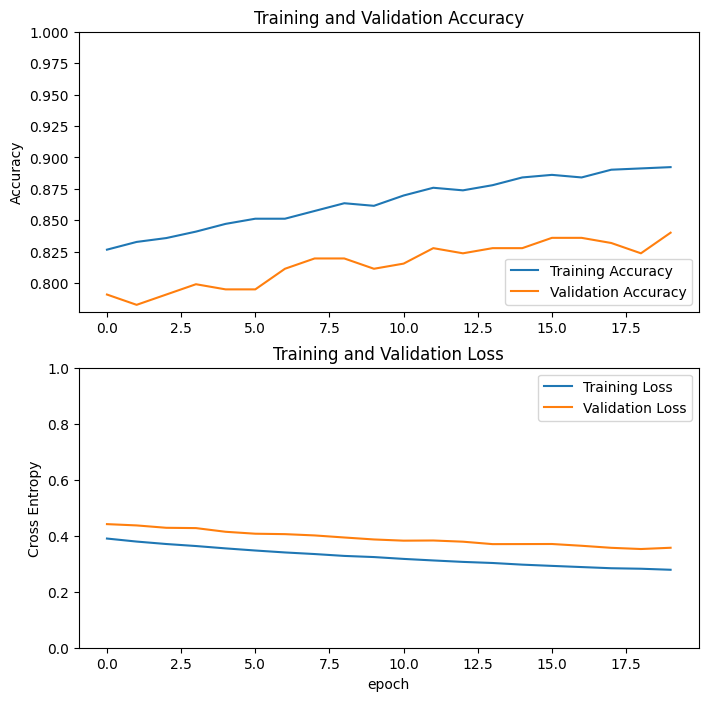

In [ ]:
# 학습곡선

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
# plt.title('Training Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
# plt.title('Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

10/10 [==============================] - 8s 852ms/step


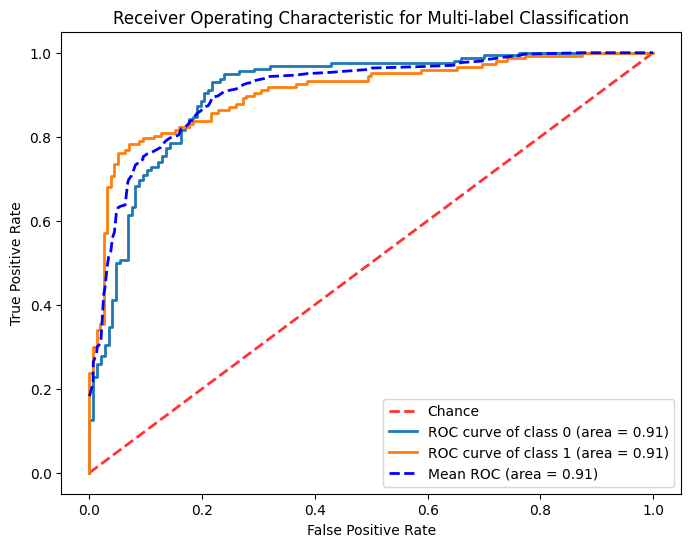

In [ ]:
# 다른 방식
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np

# 모델의 예측을 얻습니다.
y_pred = model.predict(X_test)

# 라벨을 원-핫 인코딩합니다.
y_true = to_categorical(y_test)


# 각 클래스에 대해 ROC 곡선과 AUC를 계산합니다.
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 2  # num_classes는 클래스의 수

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 모든 클래스에 대한 평균 ROC 곡선과 AUC를 계산합니다.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# 모든 클래스에 대한 ROC 곡선과 AUC를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, color='b', linestyle='--', lw=2, label='Mean ROC (area = {0:0.2f})'.format(roc_auc["macro"]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-label Classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 미세조정 - 안 해도 됨



# 최상위 층 고정 해제하기
base_model.trainable = True




# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))




# Fine-tune from this layer onwards
fine_tune_at = 100




# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False




model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])




model.summary()



len(model.trainable_variables)




# 모델 훈련 계속

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(images_array,labels_array,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_split=0.2)



acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



loss, accuracy = model.evaluate(images_array,labels_array)
print('Test accuracy :', accuracy)


# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Object `원핫인코딩했나` not found.
